# Forecasting OPEC Basket Oil Price and Its Volatilities Using LSTM
#### Acknowledgment: I would like to express my deepest gratitude to Jason Brownlee, whose tutorials were invaluable in making this project possible. His comprehensive guides on LSTM prediction, can be found here https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

#### Import Necessary Libraries and Modules


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import time
import datetime
from scipy import stats  
import seaborn as sns


#### Loading the dataset


In [42]:
tf.random.set_seed(7)
dataframe = pd.read_csv('Oil.csv', usecols=[0, 1], engine='python')
dataset = dataframe.iloc[:, 1].values
dataset = dataset.astype('float32').reshape(-1, 1)
print('dataset.shape',dataset.shape ,'\nIts Value', '\n',dataset)

dataset.shape (5531, 1) 
Its Value 
 [[30.05]
 [30.83]
 [30.71]
 ...
 [80.93]
 [82.36]
 [83.1 ]]


#### plot the original Data

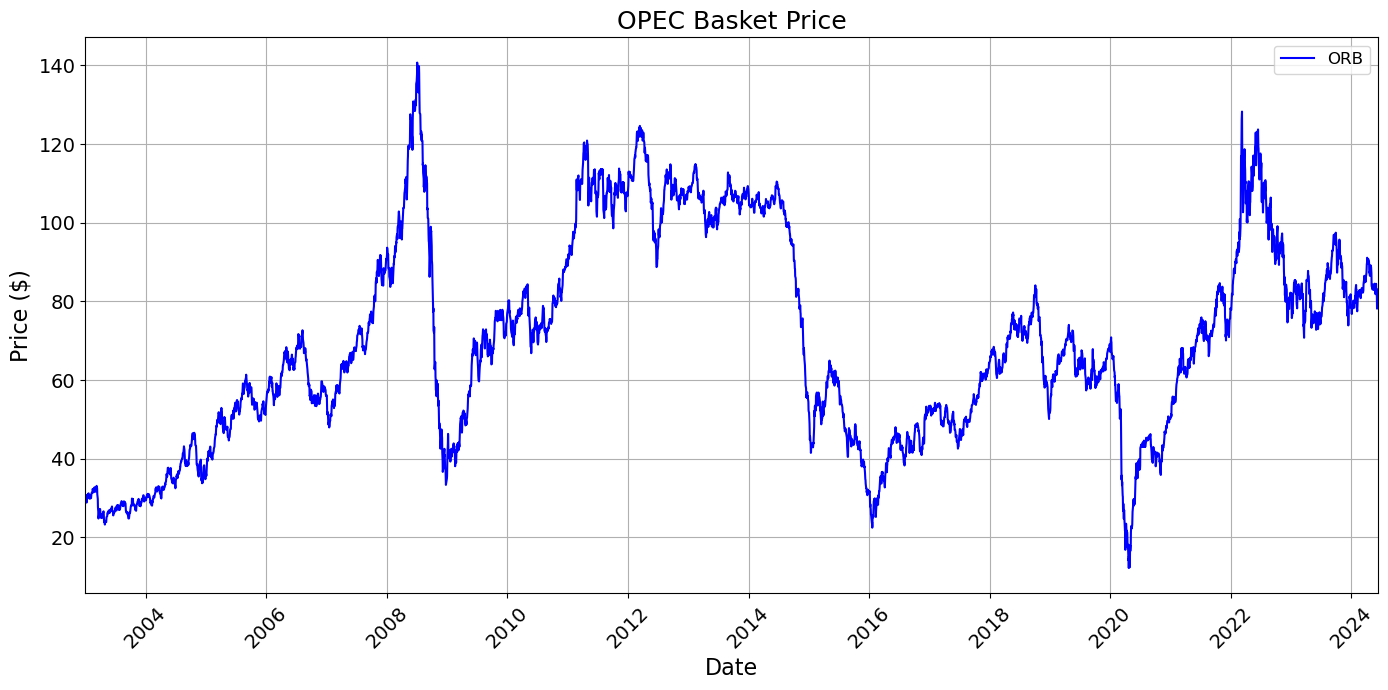

In [44]:
#plot the original Data
date_column = dataframe.columns[0]
# Convert the date column to datetime, specifying the correct format
dates = pd.to_datetime(dataframe[date_column], dayfirst=True)

# Plot the dataset
plt.figure(figsize=(14, 7))
plt.plot(dates, dataset, label='ORB', color='blue')

# Adding title and labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.title('OPEC Basket Price', fontsize=18)

# Configure the x-axis to display dates properly
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
start_date = pd.to_datetime('2003-01-01')
end_date = pd.to_datetime('2024-06-12')
ax.set_xlim([start_date, end_date])

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.legend(fontsize=12)

plt.tight_layout()

# Show the plot
plt.savefig('ORIGINAL_data.png')

plt.show()


#### Data preprocessing
1.  missing values
2.  Outlier removal

#### missing values


In [46]:
# Check for missing values
missing_values_count = np.isnan(dataset).sum()
print(f'Number of missing values: {missing_values_count}')

# Apply backward filling to handle missing values
if missing_values_count > 0:
    dataset = pd.DataFrame(dataset).fillna(method='bfill').values

# Print the updated dataset
print('dataset.shape', dataset.shape, '\nIts Value', '\n', dataset)

Number of missing values: 0
dataset.shape (5531, 1) 
Its Value 
 [[30.05]
 [30.83]
 [30.71]
 ...
 [80.93]
 [82.36]
 [83.1 ]]


#### Mean and Standard Deviation 

In [48]:
mean_value = np.mean(dataset)
std_dev = np.std(dataset)

# Print the results
print(f'Mean of the dataset: {mean_value}')
print(f'Standard Deviation of the dataset: {std_dev}')

Mean of the dataset: 70.16722869873047
Standard Deviation of the dataset: 26.255027770996094


#### Outlier removal


In [50]:
z_scores = np.abs(stats.zscore(dataset))
dataset = dataset[z_scores < 3].reshape(-1, 1)

print('Dataset shape after outlier removal:', dataset.shape)

Dataset shape after outlier removal: (5531, 1)


#### Normalize the dataset

In [52]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print('scaled dataset', '\n',dataset)

scaled dataset 
 [[0.13874406]
 [0.14481363]
 [0.14387985]
 ...
 [0.53466654]
 [0.5457941 ]
 [0.5515524 ]]


#### Model Configuration Parameters


In [54]:
split = 0.65
lstm_units = 100
epochs = 10
look_back = 1

#### Function to Create Dataset for Time Series Prediction
##### 1. This function transforms the input dataset into a format suitable for time series prediction using LSTM
##### 2. It creates sequences of data (dataX) and corresponding labels (dataY) based on the specified look-back period.


In [56]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


#### Prepare Training and Testing Data for LSTM Model
##### 1. The dataset is split into training and testing sets based on the specified split ratio. 
##### 2. The create_dataset function is then used to generate sequences (trainX, testX) and their corresponding labels (trainY, testY) for time series prediction.
##### 3. The data is reshaped to fit the input format required by the LSTM model.

In [62]:

# Split the dataset
train_size = int(len(dataset) * split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Create the dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


trainX.shape


(3594, 1, 1)

#### Build, Compile, and Train the LSTM Network
##### 1. The model is compiled with Mean Squared Error as the loss function 
##### 2.  Adam is the optimizer.
##### 3.  The model is  trained on the prepared training data, with the training time being recorded.


In [64]:



model = Sequential()
model.add(LSTM(lstm_units,  input_shape = (look_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)
end_time = time.time()
training_time = end_time - start_time


C:\Users\abo__\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3594/3594 - 9s - 2ms/step - loss: 0.0038
Epoch 2/10
3594/3594 - 5s - 2ms/step - loss: 1.1970e-04
Epoch 3/10
3594/3594 - 6s - 2ms/step - loss: 1.1486e-04
Epoch 4/10
3594/3594 - 5s - 1ms/step - loss: 1.1211e-04
Epoch 5/10
3594/3594 - 5s - 1ms/step - loss: 1.1050e-04
Epoch 6/10
3594/3594 - 5s - 1ms/step - loss: 1.0937e-04
Epoch 7/10
3594/3594 - 5s - 1ms/step - loss: 1.0850e-04
Epoch 8/10
3594/3594 - 5s - 1ms/step - loss: 1.0764e-04
Epoch 9/10
3594/3594 - 5s - 1ms/step - loss: 1.0692e-04
Epoch 10/10
3594/3594 - 5s - 1ms/step - loss: 1.0627e-04


#### Model Predictions and Performance Evaluation

##### 1. Make Predictions
This section makes predictions on both the training and testing datasets using the trained LSTM model.

##### 2. Invert Predictions
The predictions are then inverted to their original scale using the scaler to interpret the results in their actual values.

##### 3. Calculate RMSE (Root Mean Squared Error)
The performance of the model is evaluated using the RMSE metric for both the training and testing datasets.

##### 4. Calculate MAE (Mean Absolute Error)
The Mean Absolute Error is calculated to assess the average magnitude of the errors in the predictions.

##### 5. Calculate MAPE (Mean Absolute Percentage Error)
The Mean Absolute Percentage Error is computed to express the prediction accuracy as a percentage.

##### 6. Print Scores and Training Time
The results are printed out, displaying the RMSE, MAE, and MAPE for both training and testing datasets, along with the total training time.
<p style="color:blue;">**Note**: You might get different results due to the stochastic nature of the Adam optimizer.</p>


In [66]:

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
#trainRMSE = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
#testRMSE = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))

# MAE
trainMAE = mean_absolute_error(trainY[0], trainPredict[:, 0])
testMAE = mean_absolute_error(testY[0], testPredict[:, 0])
#MAPE
trainMAPE=mean_absolute_percentage_error(trainY[0], trainPredict[:, 0])
testMAPE=mean_absolute_percentage_error(testY[0], testPredict[:, 0])

print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')

print(f'Train Score: {trainMAE:.2f} MAE')
print(f'Test Score: {testMAE:.2f} MAE')

print(f'Train Score: {trainMAPE:.2f} MAPE')
print(f'Test Score: {testMAPE:.2f} MAPE')

print(f'Training Time: {training_time:.2f} seconds')


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 1.11 RMSE
Test Score: 1.44 RMSE
Train Score: 0.81 MAE
Test Score: 0.99 MAE
Train Score: 0.01 MAPE
Test Score: 0.02 MAPE
Training Time: 56.59 seconds


#### Plotting Actual vs Predicted OPEC Basket Prices

##### 1. Extract Dates from the Original Dataset
Extracting the dates from the original dataset and converting them into a datetime format.
##### 2. Shift Train Predictions for Plotting
The training predictions are shifted to align with the actual data for accurate visualization. An empty array with the same shape as the dataset is created, and the predictions are inserted at the correct positions.

##### 3. Shift Test Predictions for Plotting
Similarly, the test predictions are shifted to align with the actual data. To ensure that the test predictions are plotted at the correct time intervals.

##### 4. Plot Baseline and Predictions
The actual OPEC Basket prices, along with the training and test predictions, are plotted on the same graph.




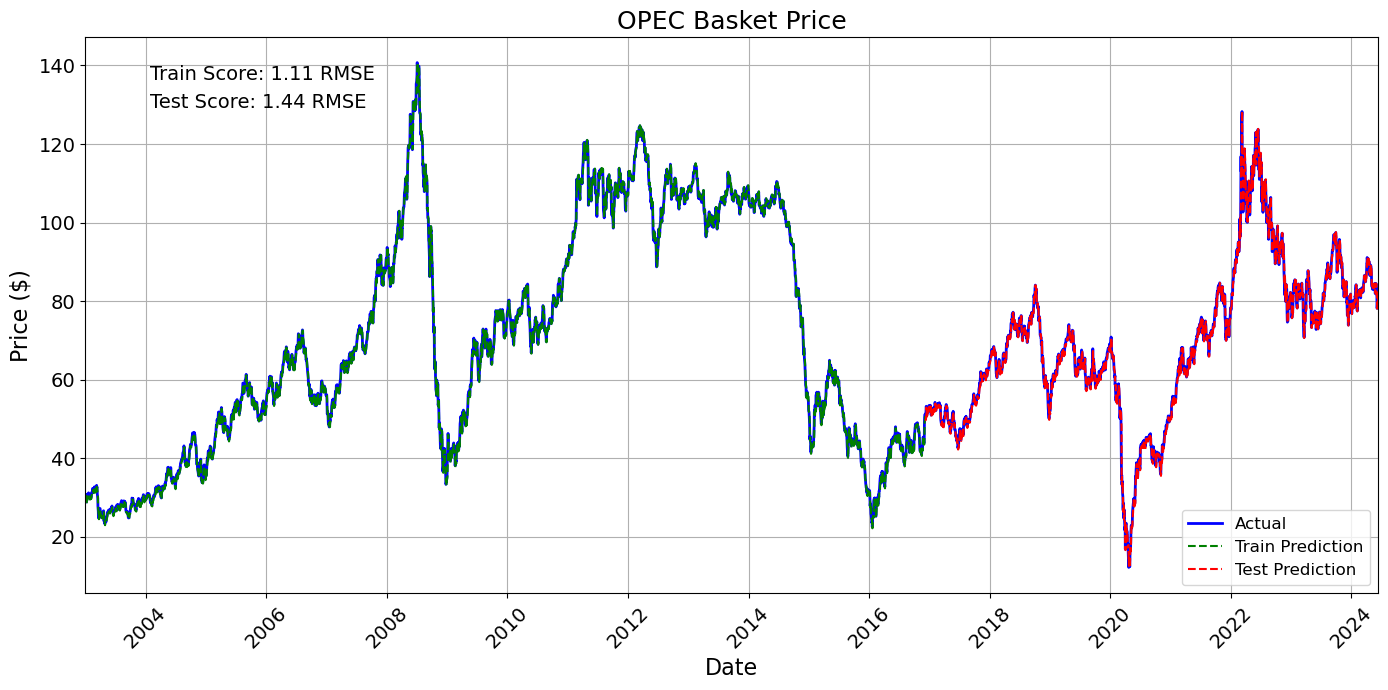

In [68]:

# Extract the dates from the original data frame
date_column = dataframe.columns[0]
dataframe[date_column] = pd.to_datetime(dataframe[date_column], format='%d/%m/%Y')
dates = dataframe[date_column].values

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2):len(trainPredict) + (look_back * 2) + len(testPredict), :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(14, 7))
plt.plot(dates, scaler.inverse_transform(dataset), label='Actual', color='blue', linewidth=2)  # Increase linewidth
plt.plot(dates, trainPredictPlot, label='Train Prediction', color='green', linestyle='--')
plt.plot(dates, testPredictPlot, label='Test Prediction', color='red', linestyle='--')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price ($)',fontsize=16)
plt.title('OPEC Basket Price',fontsize=18)

# Add train and test scores
plt.text(0.05, 0.95, f'Train Score: {trainScore:.2f} RMSE', transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top')
plt.text(0.05, 0.90, f'Test Score: {testScore:.2f} RMSE', transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top')

plt.legend(loc='lower right',fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
start_date = pd.to_datetime('2003-01-01')
ax.set_xlim([start_date, dataframe[date_column].max()])

plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


#### Filtering and Plotting OPEC Basket Price for the Year 2020

##### 1. Convert Dates to Datetime Format
The dates are converted to a pandas datetime format.

##### 2. Filter Data for the Year 2020

##### 3. Plot Actual vs Test Predictions for 2020
The filtered data is plotted to compare the actual OPEC Basket prices against the model's test predictions for the year 2020. 

##### 4. Format the X-Axis for Dates
The x-axis is formatted to display months within the year 2020



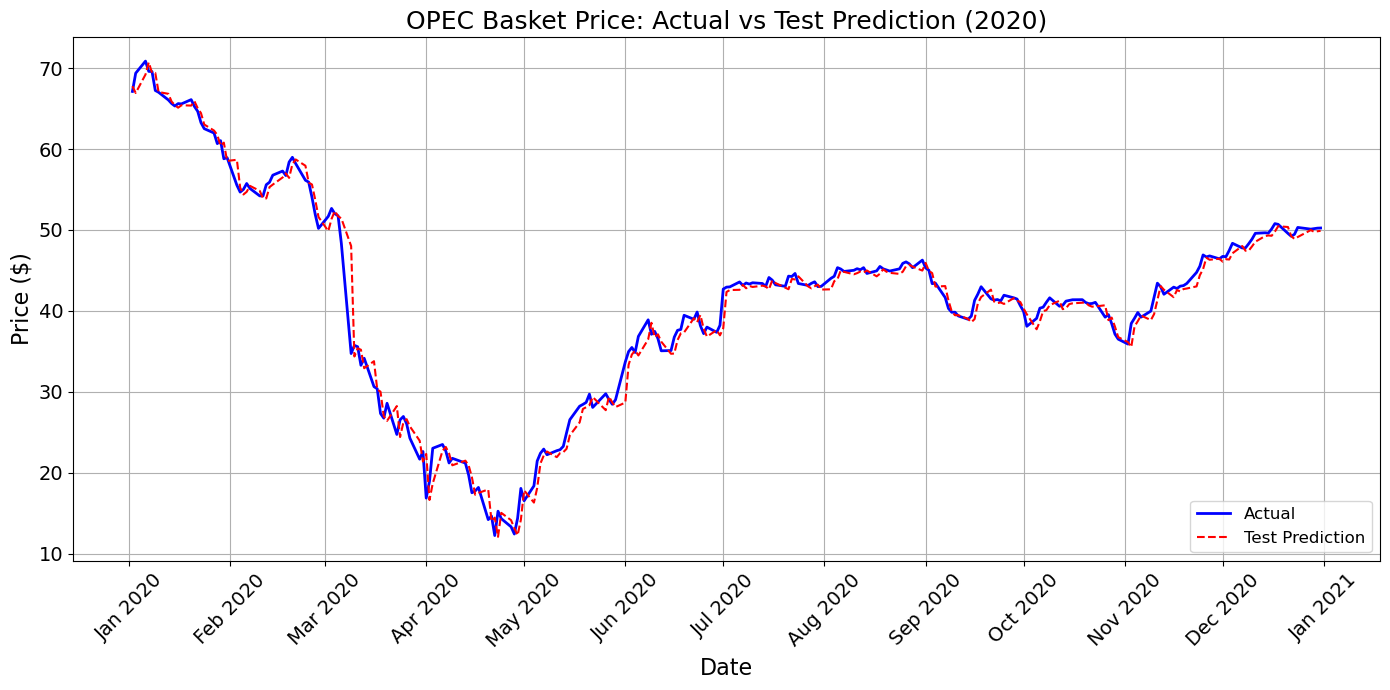

In [70]:

# Convert dates to a pandas datetime format for easier filtering
dates = pd.to_datetime(dates)

# Filter data for the year 2020
mask = (dates >= pd.to_datetime('2020-01-01')) & (dates <= pd.to_datetime('2020-12-31'))
dates_2020 = dates[mask]
actual_2020 = scaler.inverse_transform(dataset)[mask]
test_2020 = testPredictPlot[mask]

# Plot actual vs. test predictions for the year 2020
plt.figure(figsize=(14, 7))
plt.plot(dates_2020, actual_2020, label='Actual', color='blue', linewidth=2)
plt.plot(dates_2020, test_2020, label='Test Prediction', color='red', linestyle='--')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.title('OPEC Basket Price: Actual vs Test Prediction (2020)', fontsize=18)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Format the x-axis for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('Zoomed2020.png')

plt.show()

#### Validation of Model Predictions Using External Dataset

##### 1. Load and Preprocess Validation Data
The validation data is loaded from a CSV file, and the date column is converted to a datetime format. The price data is then scaled to a range between 0 and 1 using MinMaxScaler.

##### 2. Prepare the Validation Data for Prediction
The validation data is prepared for prediction by creating input sequences (VaildDataX) and corresponding labels (VaildDataY) using the `create_dataset` function. The input data is reshaped to match the expected format for the LSTM model.

##### 3. Make Predictions on the Validation Data
The trained LSTM model is used to make predictions on the validation data. The predictions are then inverted back to the original scale to be compared with the actual values.

##### 4. Evaluate Model Performance on Validation Data
The model's performance is evaluated on the validation data using RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and MAPE (Mean Absolute Percentage Error) metrics. These scores provide insights into the accuracy of the model's predictions on unseen data.

##### 5. Plot Actual vs Predicted Prices for Validation Data
The actual and predicted prices are plotted to visually compare the model's performance on the validation dataset.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Validation Score: 1.02 RMSE
Validation Score: 0.76 MAE
Validation Score: 0.01 MAPE


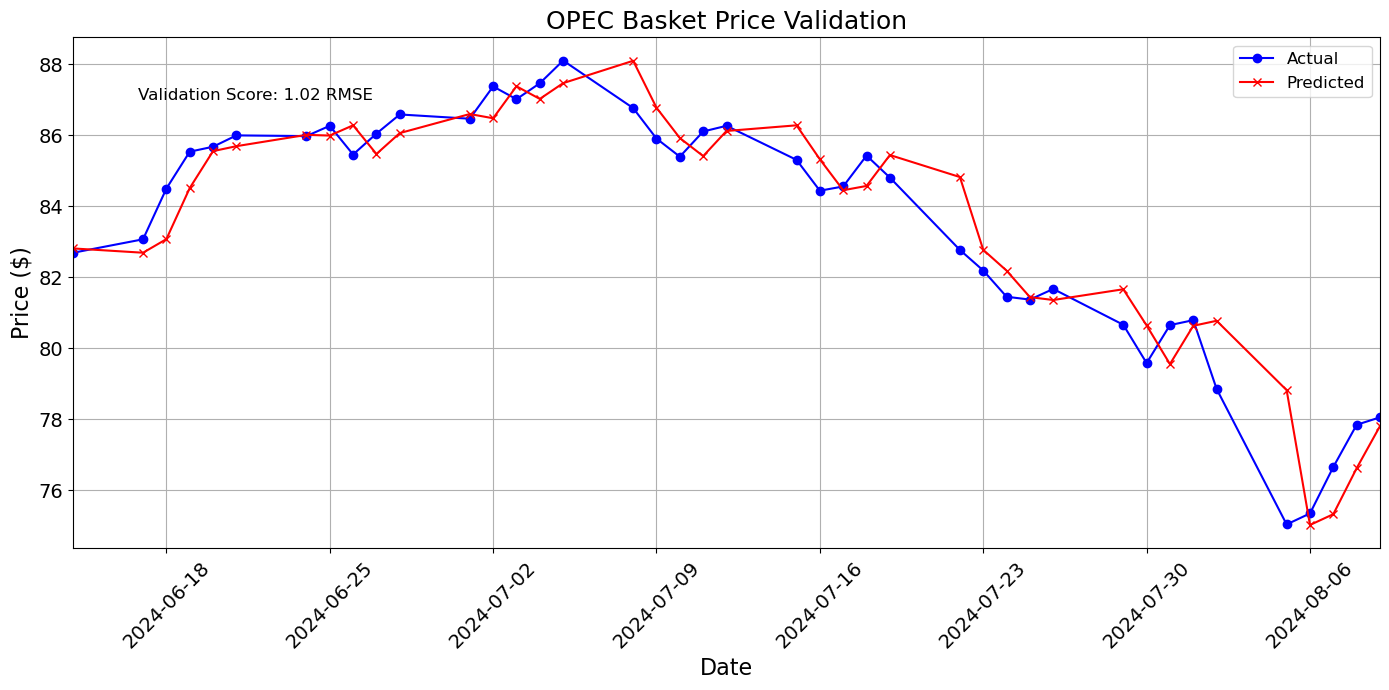

In [72]:
valid_data = pd.read_csv('VaildData.csv', usecols=[0, 1], engine='python')
valid_data.columns = ['Date', 'Price']
valid_data['Date'] = pd.to_datetime(valid_data['Date'], format='%d/%m/%Y')
dates = valid_data['Date']
scaler = MinMaxScaler(feature_range=(0, 1))
valid_data_Values = scaler.fit_transform(valid_data['Price'].values.astype('float32').reshape(-1, 1))
# Prepare the test data for prediction
VaildDataX, VaildDataY = create_dataset(valid_data_Values, look_back)

# Reshape input to be [samples, time steps, features]
VaildDataX = np.reshape(VaildDataX, (VaildDataX.shape[0], look_back, 1))

# Make predictions
VaildDataPredict = model.predict(VaildDataX)

# Invert predictions
VaildDataPredict = scaler.inverse_transform(VaildDataPredict)
VaildDataY = scaler.inverse_transform(VaildDataY.reshape(-1, 1))
valid_data_dates = dates[look_back:look_back + len(VaildDataPredict)]
VaildDataY = np.array(VaildDataY).reshape(-1)  # Reshape to (41,)
VaildDataPredict = np.array(VaildDataPredict)

# RMSE Vaildation
VaildDataScoreRMSE = np.sqrt(mean_squared_error(VaildDataY,VaildDataPredict[:, 0] ))
print(f'Validation Score: {VaildDataScoreRMSE:.2f} RMSE')

# MAE
VaildDataScoreMAE = mean_absolute_error(VaildDataY, VaildDataPredict[:, 0])
print(f'Validation Score: {VaildDataScoreMAE:.2f} MAE')
#MAPE
VaildDataScoreMAPE = mean_absolute_percentage_error(VaildDataY, VaildDataPredict[:, 0])

print(f'Validation Score: {VaildDataScoreMAPE:.2f} MAPE')

plt.figure(figsize=(14, 7))
plt.plot(valid_data_dates, VaildDataY, label='Actual', color='blue', marker='o')
plt.plot(valid_data_dates, VaildDataPredict, label='Predicted', color='red', marker='x')
plt.text(0.05, 0.90, f'Validation Score: {VaildDataScoreRMSE:.2f} RMSE', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top')
# Formatting the plot
# Formatting the plot
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.title('OPEC Basket Price Validation', fontsize=18)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
start_date = pd.to_datetime('2024-06-14')
ax.set_xlim([start_date, dates.max()])

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('The Validation Test.png')
plt.show()

